# Using Pipelines in Grid Searches

Data from Kaggle Project of **Heart Disease**
https://www.kaggle.com/ronitf/heart-disease-uci

Consider following problems:
- Dummy category columns before dataset splitting.
- Scaling data only in each training splited fold during grid search cross validation process.

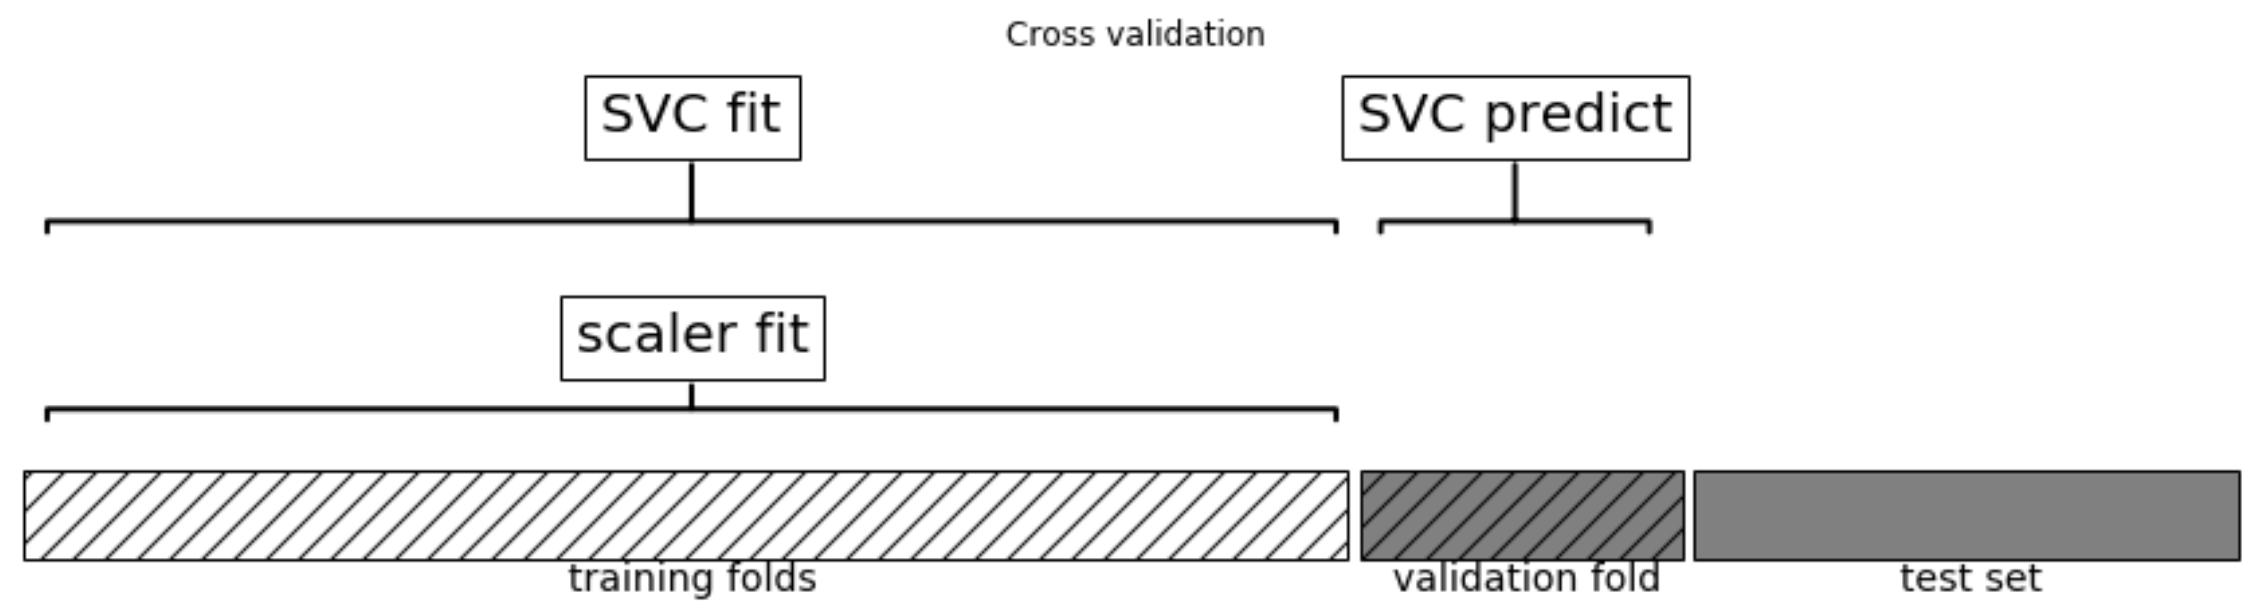

In [1]:
from IPython.display import Image,display

display(Image("../fig/cv_scaler.png", width=800))

<font color='red'>** Discussion**</font>

- Here, for each split in the cross-validation, the *Scaler* is refit with **only the training splits** and no information is leaked from the test split into the parameter search.
- Impact of leaking information:
    - Depending on the nature of the preprocessing stes.
    - **Estimating the scale of the data** using the test fold usually doesn't have a terrible impact
    - Using the test fold in **feature extraction and feature selection** can lead to substantial differences in outcomes.

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('heart_disease_clean.csv')
df.drop(df.columns[0],axis=1,inplace=True) 
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_indeced_angina,ST_depression,ST_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/dl,normal,150,No,2.3,upsloping,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/dl,ST-T wave abnormality,187,No,3.5,upsloping,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/dl,normal,172,No,1.4,downsloping,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/dl,ST-T wave abnormality,178,No,0.8,downsloping,0,fixed defect,1
4,57,female,Unknown,120,354,lower than 120mg/dl,ST-T wave abnormality,163,Yes,0.6,downsloping,0,fixed defect,1


# Preparing Pipeline for Data
## Get Cat. name and Num. name

In [4]:
CatAttribs = df.select_dtypes(include='object').columns
NumAttribs = df.select_dtypes(include=np.number).columns[:-1]
print("Category columns' Name are: {}".format(CatAttribs))
print("Numerical columns' Name are: {}".format(NumAttribs))

Category columns' Name are: Index(['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg',
       'exercise_indeced_angina', 'ST_slope', 'thalassemia'],
      dtype='object')
Numerical columns' Name are: Index(['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate',
       'ST_depression', 'num_major_vessels'],
      dtype='object')


## Dummy for Cat. columns
Get dummies for categorical features, <font color='blue'>**This step should be done before dataset splitting in order to ensure categorical values are represented in the same way in the training set and the test set.**

In [5]:
df = pd.get_dummies(df,drop_first=True)
df.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,ST_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/dl,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_indeced_angina_Yes,ST_slope_flat,ST_slope_upsloping,thalassemia_normal,thalassemia_reversable defect,thalassemia_unknown
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


In [6]:
X = df.drop('target',1)
y = df['target']

In [7]:
CatAttribsDM = [item for item in X.columns if item not in NumAttribs]

## Scaling Num. column

In [8]:
from sklearn.base import BaseEstimator,TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,feature_names):
        self.feature_names = feature_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.feature_names]

In [9]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler

num_pipeline = Pipeline([
               ('selector',DataFrameSelector(NumAttribs)),      
               ('std_scaler',RobustScaler()),
              ])

cat_pipeline = Pipeline([
               ('selector',DataFrameSelector(CatAttribsDM)),
               ])

transformer = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline),])

# Splitting Data

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 42)

In [11]:
print("X_train: {}, y_train: {}, X_test: {}, y_test: {}"
      .format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

X_train: (242, 19), y_train: (242,), X_test: (61, 19), y_test: (61,)


# Model Training

In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score,classification_report

def gridSearchCVReport():
    print("Grid Search with ROC AUC")
    print("\n Train Set ")
    print("Best parameters on Train set:", grid.best_params_)
    print("Best Cross-Validation score (AUC) on Train set:", grid.best_score_)
    print("\n Test Set")    
    print("Test set AUC:", roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])) 
    print("Test set accuracy:", grid.best_estimator_.score(X_test, y_test))

## Pipeline inside GridSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)

In [14]:
from sklearn.linear_model import SGDClassifier

pipe = Pipeline([('tran',transformer), 
                 ('sgd',SGDClassifier(loss='log',max_iter=100))])

<font color='red'>**parameter grid for a pipeline** <font color='blue'>is to specify for each parameter the step name, followed by __(a double underscore),followed by the parameter name.</font> 

In [15]:
# SGD Classifier parameters
sgd_clf_params = {"sgd__penalty": ['l1', 'l2']}

grid = GridSearchCV(pipe, 
                    sgd_clf_params, 
                    cv=kfold, 
                    scoring ='roc_auc')
grid.fit(X_train, y_train)

# SGDClassifier best parameters.
sgd_clf = grid.best_estimator_

gridSearchCVReport()

print(classification_report(y_test,sgd_clf.predict(X_test)))

Grid Search with ROC AUC

 Train Set 
Best parameters on Train set: {'sgd__penalty': 'l2'}
Best Cross-Validation score (AUC) on Train set: 0.8871594350452701

 Test Set
Test set AUC: 0.9418103448275862
Test set accuracy: 0.8852459016393442
             precision    recall  f1-score   support

          0       0.87      0.90      0.88        29
          1       0.90      0.88      0.89        32

avg / total       0.89      0.89      0.89        61

